# Tools to understand the behavior of ML algorithms - Hands-on tutorials

In this notebook, we provide step-by-step guides for geting started using 2 Microsoft Responsible AI techniques for protecting AI systems data:

- **Data Anonymization** with [Presidio](https://github.com/Microsoft/presidio)
- **Differencial Privacy** with the [SmartNoise system](https://github.com/opendp/smartnoise-core)

These are inspired by the example notebooks provided in each repo, and are meant to get aggregate all these tools into a single document to get you started as quickly as possible.

## Presidio

Presidio is a data protection and anonymization SDK for text and images providing fast identification and anonymization of private entities in text such as credit card numbers, names, locations, social security numbers, bitcoin wallets, US phone numbers, financial data and more.

In this tutorial, we introduce two of Presidio's modules, namely 
1. **Presidio analyzer** for custom or predefined PII detection in text, leveraging Named Entity Recognition, regular expressions, rule-based logic, and checksum with relevant context in multiple languages, and 
2. **Presidio anonymizer** which is the module allowing anonymization of the detected PII entities using different operators. 

To get there, we follow 4 simple steps to show how Presidio works.

**Step 1:** Installing the presidio_analyzer and presidio_anonymizer libraries using pip along with the spaCy English language model needed by the analyzer.

In [1]:
# Installing packages if not already done
# !pip install presidio_analyzer 
# !pip install presidio_anonymizer

# Presidio analyzer requires a spaCy language model. 
# !python -m spacy download en_core_web_lg

# Importing the required modules
from presidio_analyzer import AnalyzerEngine, PatternRecognizer
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities.engine import OperatorConfig

**Step 2:** Once the presidio-analyzer package is installed, run this simple analysis script. This will print the result of the PII analysis, in this case the detected phone numbers in the provided text.

In [2]:
text_to_anonymize = "His name is Mr. Jones and his phone number is 212-555-5555"
analyzer = AnalyzerEngine()
analyzer_results = analyzer.analyze(text=text_to_anonymize, entities=["PHONE_NUMBER"], language='en')

print(analyzer_results)

[2021-07-19 13:41:26,573] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'His'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-07-19 13:41:26,577] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-07-19 13:41:26,579] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-07-19 13:41:26,581] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Mr.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-07-19 13:41:26,582] [W

[type: PHONE_NUMBER, start: 46, end: 58, score: 1.0]


**Step 3:**  Creating Custom PII Entity Recognizers.

In [8]:
from presidio_analyzer import PatternRecognizer

text_to_anonymize = "His name is Mr. Jones and his phone number is 212-555-5555" 
titles_recognizer = PatternRecognizer(supported_entity="TITLE",
                                      deny_list=["Mr.","Mrs.","Miss"])
pronoun_recognizer = PatternRecognizer(supported_entity="PRONOUN",
                                      deny_list=["he", "his", "she", "hers"])
analyzer.registry.add_recognizer(titles_recognizer)
analyzer.registry.add_recognizer(pronoun_recognizer)

analyzer_results = analyzer.analyze(text=text_to_anonymize, language='en')

analyzer_results

[2021-07-19 13:48:34,249] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'His'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-07-19 13:48:34,251] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'name'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-07-19 13:48:34,253] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'is'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-07-19 13:48:34,254] [WARNING] [W108] The rule-based lemmatizer did not find POS annotation for the token 'Mr.'. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
[2021-07-19 13:48:34,255] [W

[type: TITLE, start: 12, end: 15, score: 1.0,
 type: PRONOUN, start: 26, end: 29, score: 1.0,
 type: PHONE_NUMBER, start: 46, end: 58, score: 1.0,
 type: PERSON, start: 16, end: 21, score: 0.85]

The previous code sample:
1. Creates custom titles and pronouns recognizers.
2. Adds the new custom recognizers to the analyzer.
3. Calls analyzer to get results from the old and new recognizers.

It prints all the PII detected including titles and pronouns we just defined.

**Step 4:**  Anonymizing the identified PII entities.

In [9]:
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities.engine import OperatorConfig


anonymizer = AnonymizerEngine()


anonymized_results = anonymizer.anonymize(
    text=text_to_anonymize,
    analyzer_results=analyzer_results,    
    operators={"DEFAULT": OperatorConfig("replace", {"new_value": "<ANONYMIZED>"}), 
               "PHONE_NUMBER": OperatorConfig("mask", {"type": "mask", "masking_char" : "*", "chars_to_mask" : 12, "from_end" : True}),
                "TITLE": OperatorConfig("redact", {})}
)

anonymized_results.to_json()


'{"text": "His name is  <ANONYMIZED> and <ANONYMIZED> phone number is ************", "items": [{"start": 59, "end": 71, "entity_type": "PHONE_NUMBER", "text": "************", "operator": "mask"}, {"start": 30, "end": 42, "entity_type": "PRONOUN", "text": "<ANONYMIZED>", "operator": "replace"}, {"start": 13, "end": 25, "entity_type": "PERSON", "text": "<ANONYMIZED>", "operator": "replace"}, {"start": 12, "end": 12, "entity_type": "TITLE", "text": "", "operator": "redact"}]}'

The previous code sample:
1. Sets up the anonymizer engine.
2. Creates an anonymizer request - text to anonymize, list of anonymizers to apply and the results from the analyzer request.
3. Anonymizes the text.

It prints the anonymized text along with a list of the detected PII entities.

## SmartNoise

### What is SmartNoise?

**SmartNoise** is a joint project by Microsoft and Harvard's Institute for Quantitative Social Science (IQSS) and the School of Engineering and Applied Sciences (SEAS) as part of the OpenDP initiative. It aims to make Differential Privacy broadly accessible.

The SmartNoise tools primarily focus on the "global model" of **Differential Privacy** where a trusted data collector is presumed to have access to unprotected data and wishes to protect public releases of aggregate information. For example, a hospital having access to patients’ information and wishing to release aggregated statistics about these patients without affecting their privacy.

SmartNoise is an open-source project that contains different components for building global differentially private systems. SmartNoise is made up of a core library and an SDK, only the [SmartNoise core library](https://github.com/opendp/smartnoise-core) is explored here.

### Goal of this tutorial and steps

In this tutorial, we will explore how data can be protected against reidentification using Differential Privacy and the SmartNoise system.
The goal is to show how an attacker can leverage basic demographic information like age and zip codes to reidentify individuals even when the sensitive data is published in an anonymized format. Then we show how Differential Privacy can help prevent such an attack. 

To get there, we follow 3 steps:
1. Import of anonymized medical data set and the attacker's data collection
2. Reidentification Attack I: Revealing identities from the anonymized data set 
3. Protecting the medical dataset with differential privacy using Multiple Weights Exponential Mechanism (MWEM)
4. Validating the utility of the synthesized data set for statistical analyses
5. Reidentification Attack II: Trying to reveal identities based on the differentially private version of the medical data set


**Step 1:** Import of anonymized medical data set and the attacker's data collection

In [1]:
# Install required libraries, uncomment if needed
# !pip install git+https://github.com/opendifferentialprivacy/smartnoise-sdk#subdirectory=sdk
# !pip install faker zipcodes tqdm opendp-smartnoise
# !pip install z3-solver==4.8.9.0

In [5]:
import warnings
warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import pandas as pd
import numpy as np
import random
import string
import uuid
import time
import logging
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils.reident_tools as reident
from opendp.smartnoise.synthesizers.mwem import MWEMSynthesizer

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Read files
df_medical = pd.read_csv('data/data_medical.csv', sep=",", encoding="utf-8").infer_objects()
df_medical['Zip'] = df_medical['Zip'].astype(str)
print('Anonymized dataset including sensitive medical information:')
display(df_medical.iloc[:,1:].sample(8))
df_demographic = pd.read_csv('data/data_demographic.csv', sep=",", encoding="utf-8").infer_objects()
print('Attacker`s data collection with basic demographic information:')
df_demographic['Zip'] = df_demographic['Zip'].astype(str)
display(df_demographic.iloc[:,1:].sample(8))
df_medical_synth = pd.read_csv('data/data_medical_synthesizer.csv', sep=",", encoding="utf-8").infer_objects()
df_medical_synth['Zip'] = df_medical_synth['Zip'].astype(str)

Anonymized dataset including sensitive medical information:


,Gender,Age,Zip,Diagnosis,Treatment,Outcome
8339,M,30-39,191**,High Blood Pressure,28,recovered
22238,F,80-89,756**,Alzheimer,38,recovered
24310,M,30-39,361**,High Blood Pressure,31,unchanged
3030,M,70-79,936**,High Blood Pressure,31,unchanged
21656,M,20-29,091**,COPD,26,intensive care
24267,F,80-89,777**,Arthritis,25,intensive care
1510,M,40-49,100**,Heart Disease,45,recovered
4077,F,50-59,218**,Stroke,24,recovered


Attacker`s data collection with basic demographic information:


,Name,Gender,Age,Zip
15268,Cory Logan,M,72,20842
2169,John Turner,M,56,39852
12222,Kimberly Rose,F,89,99019
27085,Jeffrey Small,M,78,49573
5414,Benjamin Barry,M,42,58290
7104,Lisa Juarez,F,77,66542
20039,Teresa Wu,F,16,14246
2751,Scott Potter,M,83,57883


**Step 2:** Reidentification Attack I: Revealing identities from the anonymized data set

In [7]:
%%time
reident_attack = reident.try_reidentification(df_demographic, df_medical, logger)

INFO:root:Performing reidentification with anonymized data: 30000. Attacker collection: 30000
100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [20:25<00:00, 24.48it/s]
INFO:root:Identified 28962 potential matches!
INFO:root:Validating IDs ...
100%|██████████████████████████████████████████████████████████████████████████| 28962/28962 [00:02<00:00, 9843.51it/s]
INFO:root:Identified 9026 actual (validated) matches!


Wall time: 20min 28s


In [8]:
print(f'Found: {len(reident_attack[reident_attack["ID_Match"]==True])} actual (validated) matches!')

Found: 9026 actual (validated) matches!


**Step 3:** Protecting the medical dataset with differential privacy using Multiple Weights Exponential Mechanism (MWEM)

First we encode the input data using the do_encode-function to make it compatible with the MWEM synthesizer. Data before encoding looks like this.

In [9]:
# Prepare data set for reidentification, using the medical data set and the full zip copied from the demographic set
df_reident_synth = df_medical[['Gender', 'Age', 'Zip', 'Diagnosis', 'Treatment', 'Outcome']].copy()
df_reident_synth['Zip'] = df_demographic['Zip'].copy()
df_reident_synth['Age'] = df_demographic['Age'].copy()
df_reident_synth.head()

,Gender,Age,Zip,Diagnosis,Treatment,Outcome
0,F,10,65418,High Blood Pressure,25,intensive care
1,F,14,65475,COPD,48,unchanged
2,F,10,65484,High Blood Pressure,38,intensive care
3,F,30,27727,Heart Disease,31,unchanged
4,F,36,27772,Diabetes,34,unchanged


Data after encoding looks like this:

In [10]:
# Encode the data set and display it
df_reident_encoded = reident.do_encode(df_reident_synth, ['Gender', 'Age', 'Zip', 'Diagnosis'], reident.diseases)
df_reident_encoded.head()

,Gender_encoded,Age_encoded,Zip_encoded,Diagnosis_encoded
0,0,10,65418,9
1,0,14,65475,2
2,0,10,65484,9
3,0,30,27727,7
4,0,36,27772,3


Now we are ready for synthesizing the fake demographic data:

In [11]:
%%time
# Apply the synthesizer to the data set
synthetic_data = MWEMSynthesizer(q_count = 400,
                        epsilon = 3.00,
                        iterations = 60,
                        mult_weights_iterations = 40,
                        splits = [],
                        split_factor = 1)
synthetic_data.fit(df_reident_encoded.to_numpy())
# Convert to dataframe
df_synthesized = pd.DataFrame(synthetic_data.sample(int(df_reident_encoded.shape[0])), columns=df_reident_encoded.columns)

Wall time: 12.4 s


Then we compare the distributions of both datasets:

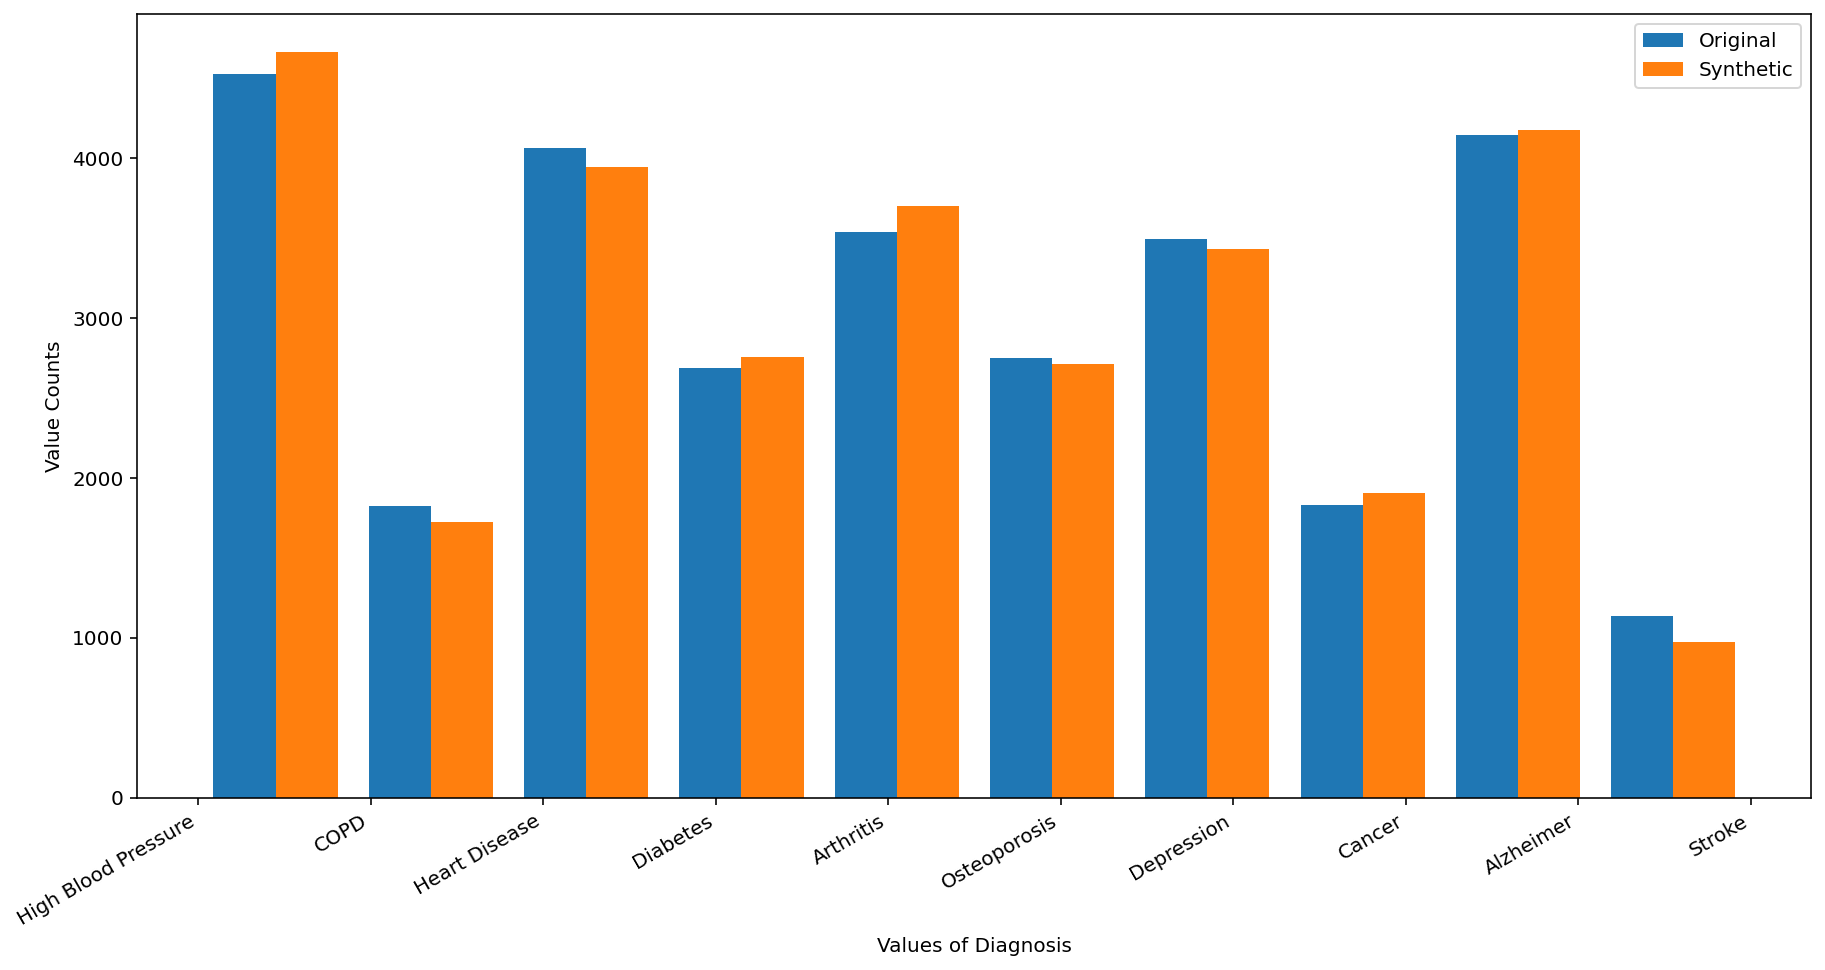

In [13]:
reident.create_histogram(df_reident_encoded, df_synthesized, 'Diagnosis_encoded', reident.diseases)

**Step 4:** Reidentification Attack II - Trying to reveal identities based on the differentially private version of the medical data set

In [14]:
reident_attack_2 = reident.try_reidentification_noise(df_synthesized, df_medical_synth, logger)

INFO:root:Trying reidentification with differential privacy-protected data: 30000. Attacker collection: 30000
INFO:root:In this setup, we can only count potential matches. We cannot validate for actual matches, as we do not have the unique patient ids after synthesizing.
100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [03:31<00:00, 141.52it/s]
INFO:root:Identified 0 potential matches!


In [15]:
print(f'Found {len(reident_attack_2)} potential matches!')
reident_attack_2.head()

Found 0 potential matches!


,ID,Gender,Age,Zip,Diagnosis,Treatment,Outcome


This time, we were able to reidentify no records at all using the synthesized. This demonstrates the magic behind Differential Privacy, it allows to protect against reidentification attacks by masking individual contributions and providing mathematical guarantees of privacy, while still preserving the distribution and thus summary statistics of the data.